### Bibliotecas que serão utilizadas

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import itertools
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve, roc_auc_score



import os
import sys

# Obtém o diretório atual de trabalho
current_dir = os.getcwd()

# Volta duas pastas até chegar ao diretório 'models'
function_path = os.path.join(current_dir, '..', '..', 'models')
sys.path.append(function_path)

import functions as func

### Lendo os dados

In [5]:
# Leitura das ABTs.
abt_train = pd.read_csv('../../databases/abt/abt_treino_fs01.csv')
abt_test = pd.read_csv('../../databases/abt/abt_teste_fs01.csv')

# Dropando a coluna "Unnamed: 0".
abt_train.drop(axis=1,columns=['Unnamed: 0'],inplace=True)
abt_test.drop(axis=1,columns=['Unnamed: 0'],inplace=True)

In [6]:
abt_train.target.describe()

count    90916.000000
mean         0.566336
std          0.495583
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: target, dtype: float64

In [7]:
# Separando as variáveis de entrada (features) e de saída (target)
X = abt_train.drop(columns=["target"])
y = abt_train["target"]

In [8]:
# Separando uma amostra de 70% para treinar o modelo e 30% para testar o modelo
# Holdout 70/30 (out-of-sample)

from sklearn.model_selection import train_test_split

# Dividindo os dados em conjunto de treinamento e teste (70% treino, 30% teste)
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.3,
                                                    random_state=42)
X_train.shape,X_test.shape

((63641, 16), (27275, 16))

### DecisionTreeClassifier

In [13]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
import numpy as np

# Definindo o modelo
model = DecisionTreeClassifier(random_state=42)

# Definindo os parâmetros para o grid search
param_grid = {
    'criterion': ['gini', 'entropy'],  
    'splitter': ['best', 'random'],  
    'max_depth': [3, 5, 10],  
    'min_samples_split': [0.01, 0.05, 0.1],  
    'min_samples_leaf': [0.02, 0.04, 0.08], 
    'max_features': ['sqrt', 'log2'],  
    'class_weight': [None, 'balanced'],  
}

# Calculando a quantidade total de modelos que serão treinados
num_models = len(list(itertools.product(*param_grid.values()))) * 5  # 5 é o número de folds na validação cruzada (cv)
print(f"Total de Modelos a serem Treinados: {num_models}")

# Definindo o objeto GridSearchCV
grid = GridSearchCV(model,
                    param_grid,
                    cv=5,
                    scoring='roc_auc',  # 'accuracy' 'precision' 'recall' 'f1'
                    n_jobs=-1)

# Treinando o modelo com o grid search
grid.fit(X_train, y_train)

# Exibindo os melhores parâmetros encontrados pelo grid search
print("Melhores Parâmetros: ", grid.best_params_)

# Exibindo a melhor pontuação (score) atingida pelo modelo com os melhores parâmetros
print("Melhor AUC: ", grid.best_score_)

# Utilizando o melhor modelo para fazer previsões
predictions = grid.best_estimator_.predict(X_test)
predprob = grid.best_estimator_.predict_proba(X_test)

gini_n = round(func.gini_normalizado(y_test, predprob[:, 1]),2)
print('Gini normalizado --> ',gini_n)

best_model_dt = grid.best_estimator_

Total de Modelos a serem Treinados: 2160
Melhores Parâmetros:  {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 0.02, 'min_samples_split': 0.01, 'splitter': 'best'}
Melhor AUC:  0.9413058568056547
Gini normalizado -->  0.89


c:\Users\jeanr\.virtualenvs\satisfaction_passenger-V9u62JBw\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


c:\Users\jeanr\Documents\projetos\classificacao\satisfaction_passenger\models\03-models\..\..\models\functions.py:366: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  decile_analysis = y_test.groupby(deciles).mean()
c:\Users\jeanr\Documents\projetos\classificacao\satisfaction_passenger\models\03-models\..\..\models\functions.py:377: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  decile_analysis_train = y_train.groupby(deciles_train).mean()


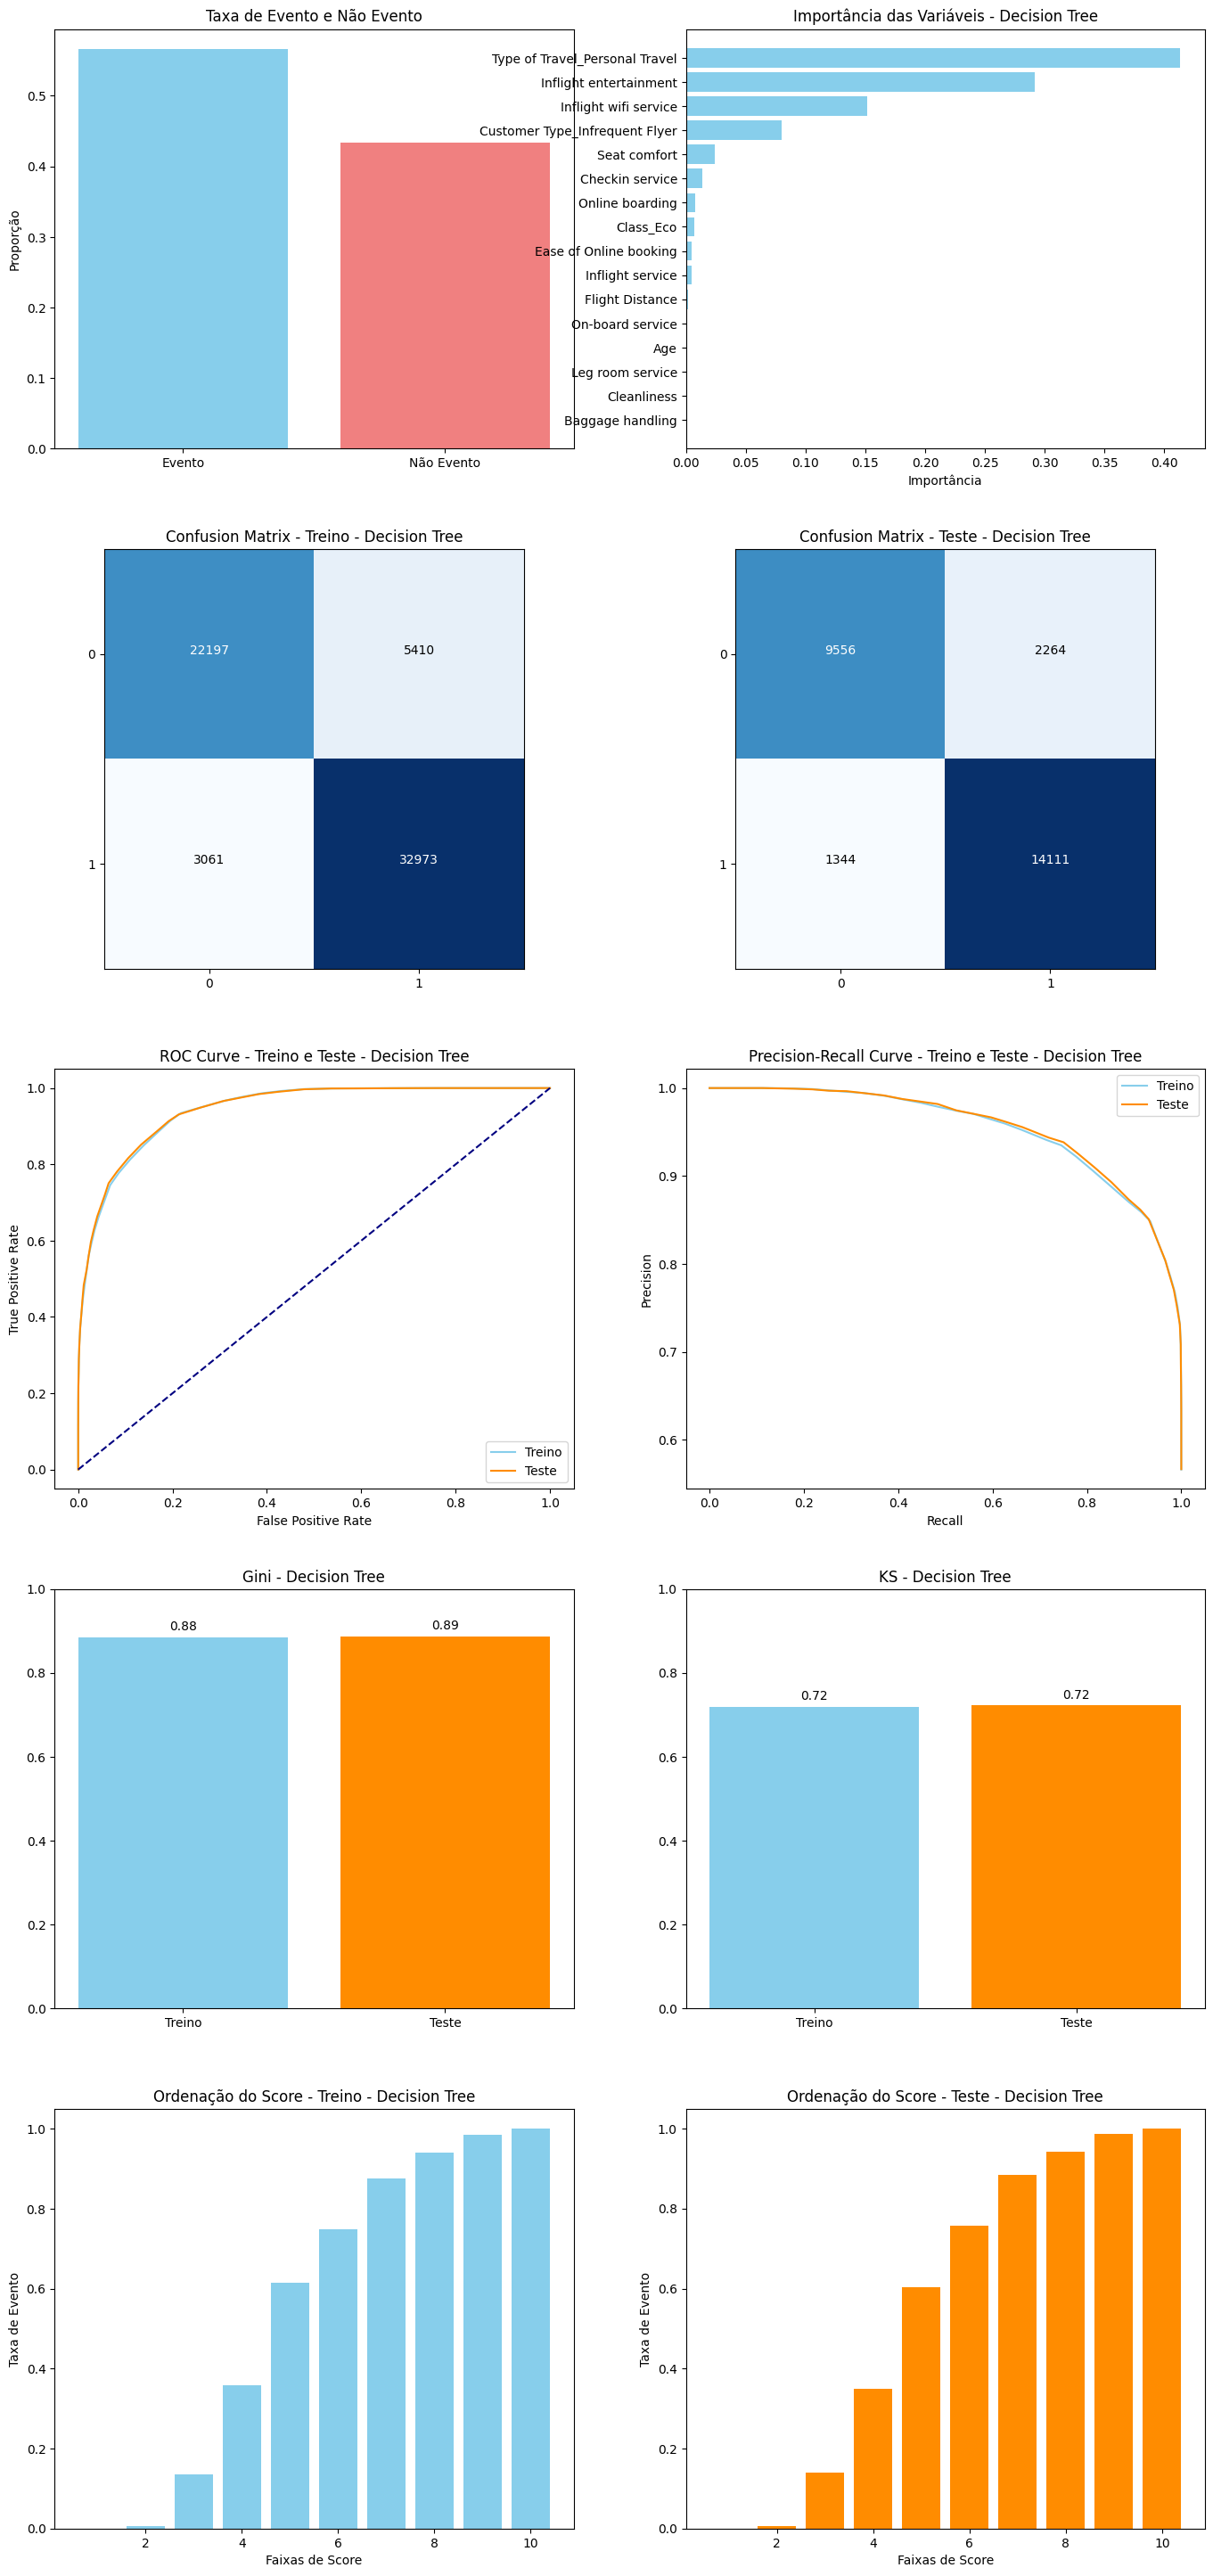

In [22]:
func.avaliar_modelo(X_train, y_train, X_test, y_test, best_model_dt,nm_modelo='Decision Tree')

### RandomForestClassifier

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import numpy as np

# Definindo o modelo
model = RandomForestClassifier(random_state=42)

# ============================================================================= Lembrete dos parâmetros do Random Forest ============================================================================= #
# n_estimators=100,    --> Número de árvores na floresta.
# criterion='gini',    --> Função para medir a qualidade de uma divisão ("gini" ou "entropy").
# max_depth=None,    --> Profundidade máxima das árvores. None significa que os nós são expandidos até ficarem puros.
# min_samples_split=2,    --> Número mínimo de amostras necessárias para dividir um nó interno.
# min_samples_leaf=1,    --> Número mínimo de amostras necessárias para estar em um nó folha.
# min_weight_fraction_leaf=0.0,    --> Fração mínima ponderada da soma total de pesos necessária para estar em um nó folha.
# max_features='auto',    --> Número de características a considerar ao procurar a melhor divisão.
# max_leaf_nodes=None,    --> Número máximo de nós folha.
# min_impurity_decrease=0.0,    --> Um nó será dividido se a divisão induzir a uma diminuição da impureza maior ou igual a este valor.
# bootstrap=True,    --> Se as amostras de bootstrap são usadas ao construir árvores.
# oob_score=False,    --> Se usar amostras out-of-bag para estimar a precisão generalizada.
# n_jobs=None,    --> Número de jobs a serem executados em paralelo para ajuste e previsão. -1 significa usar todos os processadores.
# random_state=None,    --> Controla a aleatoriedade do bootstrap e da seleção de features.
# verbose=0,    --> Controla a verbosidade do processo de treinamento.
# warm_start=False,    --> Reutiliza a solução da chamada anterior para ajustar e adicionar mais estimadores ao ensemble.
# class_weight=None,    --> Pesos associados às classes. Pode ser "balanced", "balanced_subsample" ou um dicionário com os pesos.
# ==================================================================================================================================================================================================== #


# Definindo os parâmetros para o grid search.
param_grid = {
    'n_estimators': [10, 50],    # Número de árvores na floresta (para modelos como RandomForest).
    'max_depth': [2, 3, 5],    # Profundidade máxima de cada árvore de decisão.
    'min_samples_split': [0.001, 0.01],    # Número mínimo de amostras necessárias para dividir um nó interno.
    'min_samples_leaf': [2, 0.01],    # Número mínimo de amostras necessárias para estar em um nó folha.
    'bootstrap': [True, False],    # Indica se amostras de bootstrap são usadas para construir árvores (para modelos como RandomForest).
    'max_features': ['sqrt', 'log2'],    # Número máximo de features a serem consideradas para dividir um nó.
    'class_weight': ['balanced', 'balanced_subsample'],
}

# Calculando a quantidade total de modelos que serão treinados
num_models = len(list(itertools.product(*param_grid.values()))) * 5  # 5 é o número de folds na validação cruzada (cv)
print(f"Total de Modelos a serem Treinados: {num_models}")

# Definindo o objeto GridSearchCV
grid = GridSearchCV(model,
                    param_grid,
                    cv=5,
                    scoring='roc_auc',  # 'accuracy' 'precision' 'recall' 'f1'
                    n_jobs=-1)

# Treinando o modelo com o grid search
grid.fit(X_train, y_train)

# Exibindo os melhores parâmetros encontrados pelo grid search
print("Melhores Parâmetros: ", grid.best_params_)

# Exibindo a melhor pontuação (score) atingida pelo modelo com os melhores parâmetros
print("Melhor AUC: ", grid.best_score_)

# Utilizando o melhor modelo para fazer previsões
predictions = grid.best_estimator_.predict(X_test)
predprob = grid.best_estimator_.predict_proba(X_test)

gini_n = round(func.gini_normalizado(y_test, predprob[:, 1]),2)
print('Gini normalizado --> ',gini_n)

best_model_rf = grid.best_estimator_

Total de Modelos a serem Treinados: 960
Melhores Parâmetros:  {'bootstrap': False, 'class_weight': 'balanced', 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 0.01, 'n_estimators': 10}
Melhor AUC:  0.9758119608939146
Gini normalizado -->  0.95


c:\Users\jeanr\Documents\projetos\classificacao\satisfaction_passenger\models\03-models\..\..\models\functions.py:366: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  decile_analysis = y_test.groupby(deciles).mean()
c:\Users\jeanr\Documents\projetos\classificacao\satisfaction_passenger\models\03-models\..\..\models\functions.py:377: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  decile_analysis_train = y_train.groupby(deciles_train).mean()


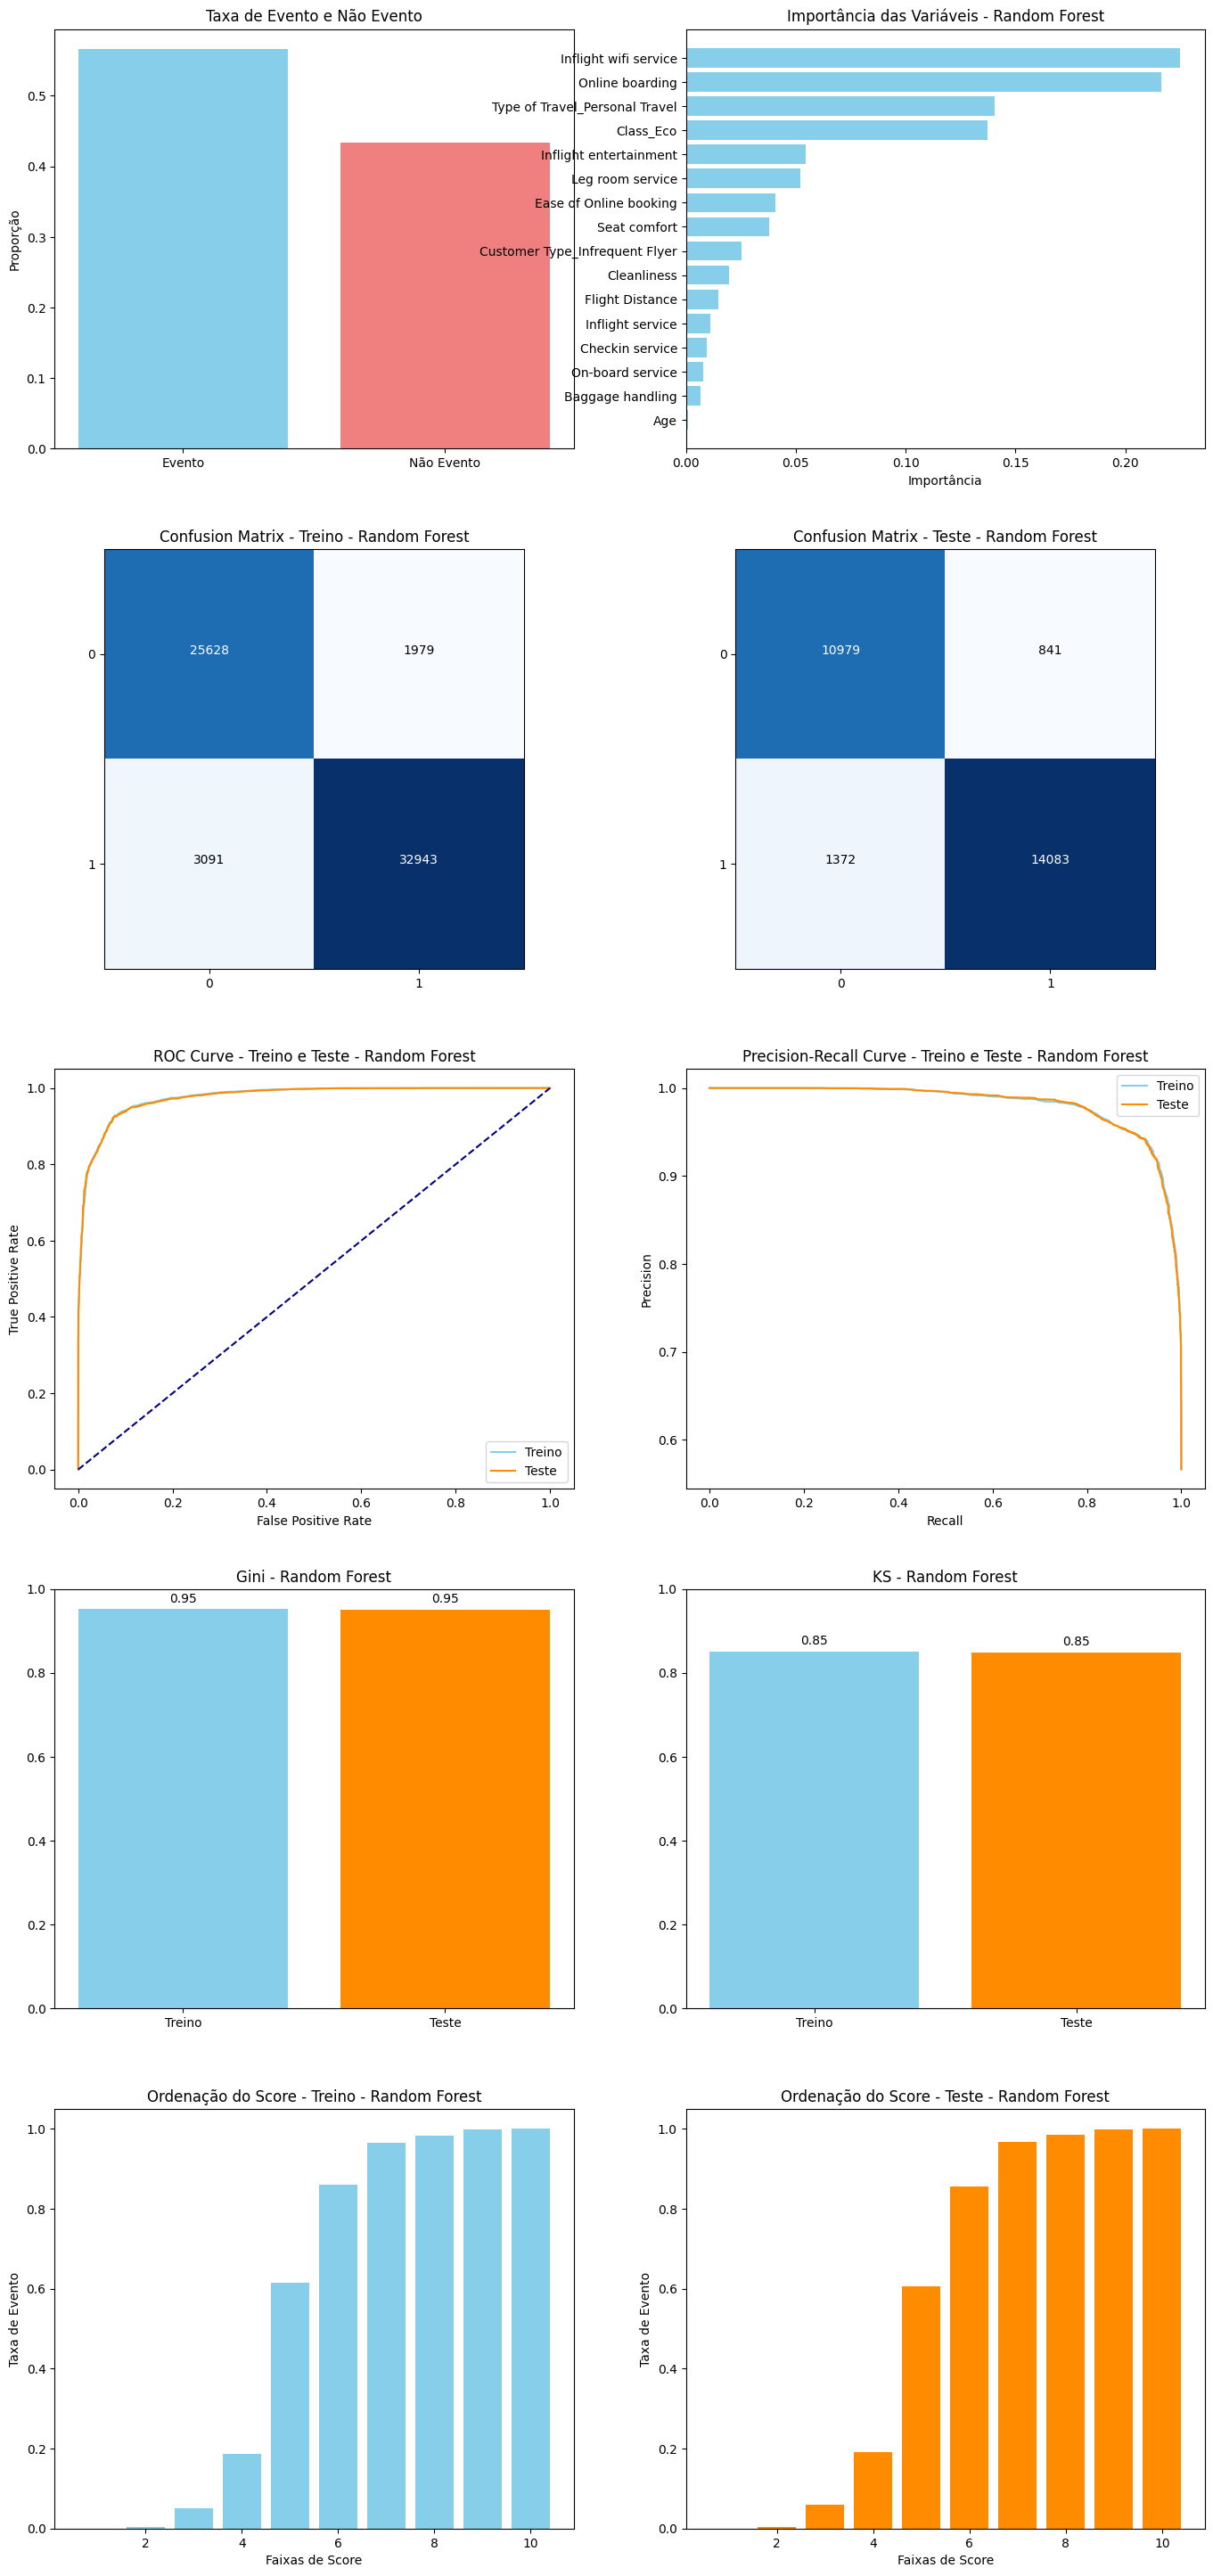

In [18]:
func.avaliar_modelo(X_train, y_train, X_test, y_test, best_model_rf,nm_modelo='Random Forest')

### GradientBoostingClassifier

In [20]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
import numpy as np

# Definindo o modelo
model = GradientBoostingClassifier(random_state=42)

# =========================================================================== Lembrete dos parâmetros do Gradient Boosting =========================================================================== #
# n_estimators=100,    --> Número de árvores na floresta.
# learning_rate=0.1,    --> Taxa de aprendizado, controla a contribuição de cada árvore.
# max_depth=3,    --> Profundidade máxima das árvores. None significa que os nós são expandidos até ficarem puros.
# min_samples_split=2,    --> Número mínimo de amostras necessárias para dividir um nó interno.
# min_samples_leaf=1,    --> Número mínimo de amostras necessárias para estar em um nó folha.
# min_weight_fraction_leaf=0.0,    --> Fração mínima ponderada da soma total de pesos necessária para estar em um nó folha.
# subsample=1.0,    --> Fração de amostras usadas para ajustar cada árvore.
# max_features=None,    --> Número de características a considerar ao procurar a melhor divisão.
# max_leaf_nodes=None,    --> Número máximo de nós folha.
# min_impurity_decrease=0.0,    --> Um nó será dividido se a divisão induzir a uma diminuição da impureza maior ou igual a este valor.
# init=None,    --> Um estimador opcional que é ajustado antes de treinar qualquer árvore.
# random_state=None,    --> Controla a aleatoriedade do bootstrap e da seleção de features.
# verbose=0,    --> Controla a verbosidade do processo de treinamento.
# warm_start=False,    --> Reutiliza a solução da chamada anterior para ajustar e adicionar mais estimadores ao ensemble.
# presort='deprecated',    --> Indica se os dados devem ser pré-ordenados para acelerar o treinamento.
# validation_fraction=0.1,    --> A fração dos dados de treinamento a serem usados como conjunto de validação para avaliar a perda de treinamento.
# n_iter_no_change=None,    --> Número máximo de iterações sem melhoria no conjunto de validação para esperar antes de interromper o ajuste.
# tol=0.0001,    --> Tolerância para parar o ajuste.
# ==================================================================================================================================================================================================== #


# Definindo os parâmetros para o grid search.
param_grid = {
    'learning_rate': [0.01, 0.1],     # Taxa de aprendizado que controla a contribuição de cada árvore na sequência de árvores no gradiente boosting.
    'n_estimators': [20, 40],     # Número de árvores de decisão a serem construídas no processo de boosting.
    'max_depth': [3, 5,],     # Profundidade máxima de cada árvore de decisão no processo de boosting.
    'min_samples_split': [2, 4],     # Número mínimo de amostras necessárias para dividir um nó interno em uma árvore de decisão.
    'min_samples_leaf': [1, 2],     # Número mínimo de amostras necessárias para estar em um nó folha em uma árvore de decisão.
    'subsample': [0.8, 0.9],     # Proporção das amostras de treinamento a serem usadas para ajustar cada árvore. Isso é útil para controlar o overfitting.
    'max_features': ['sqrt', 'log2'],     # Número máximo de features a serem consideradas ao procurar a melhor divisão em uma árvore de decisão. Pode ser 'sqrt', 'log2' ou None (significando todas as features).
}
# Calculando a quantidade total de modelos que serão treinados
num_models = len(list(itertools.product(*param_grid.values()))) * 5  # 5 é o número de folds na validação cruzada (cv)
print(f"Total de Modelos a serem Treinados: {num_models}")

# Definindo o objeto GridSearchCV
grid = GridSearchCV(model,
                    param_grid,
                    cv=5,
                    scoring='roc_auc',  # 'accuracy' 'precision' 'recall' 'f1'
                    n_jobs=-1)

# Treinando o modelo com o grid search
grid.fit(X_train, y_train)

# Exibindo os melhores parâmetros encontrados pelo grid search
print("Melhores Parâmetros: ", grid.best_params_)

# Exibindo a melhor pontuação (score) atingida pelo modelo com os melhores parâmetros
print("Melhor AUC: ", grid.best_score_)

# Utilizando o melhor modelo para fazer previsões
predictions = grid.best_estimator_.predict(X_test)
predprob = grid.best_estimator_.predict_proba(X_test)

gini_n = round(func.gini_normalizado(y_test, predprob[:, 1]),2)
print('Gini normalizado --> ',gini_n)

best_model_gb = grid.best_estimator_

Total de Modelos a serem Treinados: 640
Melhores Parâmetros:  {'learning_rate': 0.1, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 40, 'subsample': 0.8}
Melhor AUC:  0.9865414042145376
Gini normalizado -->  0.97


c:\Users\jeanr\Documents\projetos\classificacao\satisfaction_passenger\models\03-models\..\..\models\functions.py:366: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  decile_analysis = y_test.groupby(deciles).mean()
c:\Users\jeanr\Documents\projetos\classificacao\satisfaction_passenger\models\03-models\..\..\models\functions.py:377: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  decile_analysis_train = y_train.groupby(deciles_train).mean()


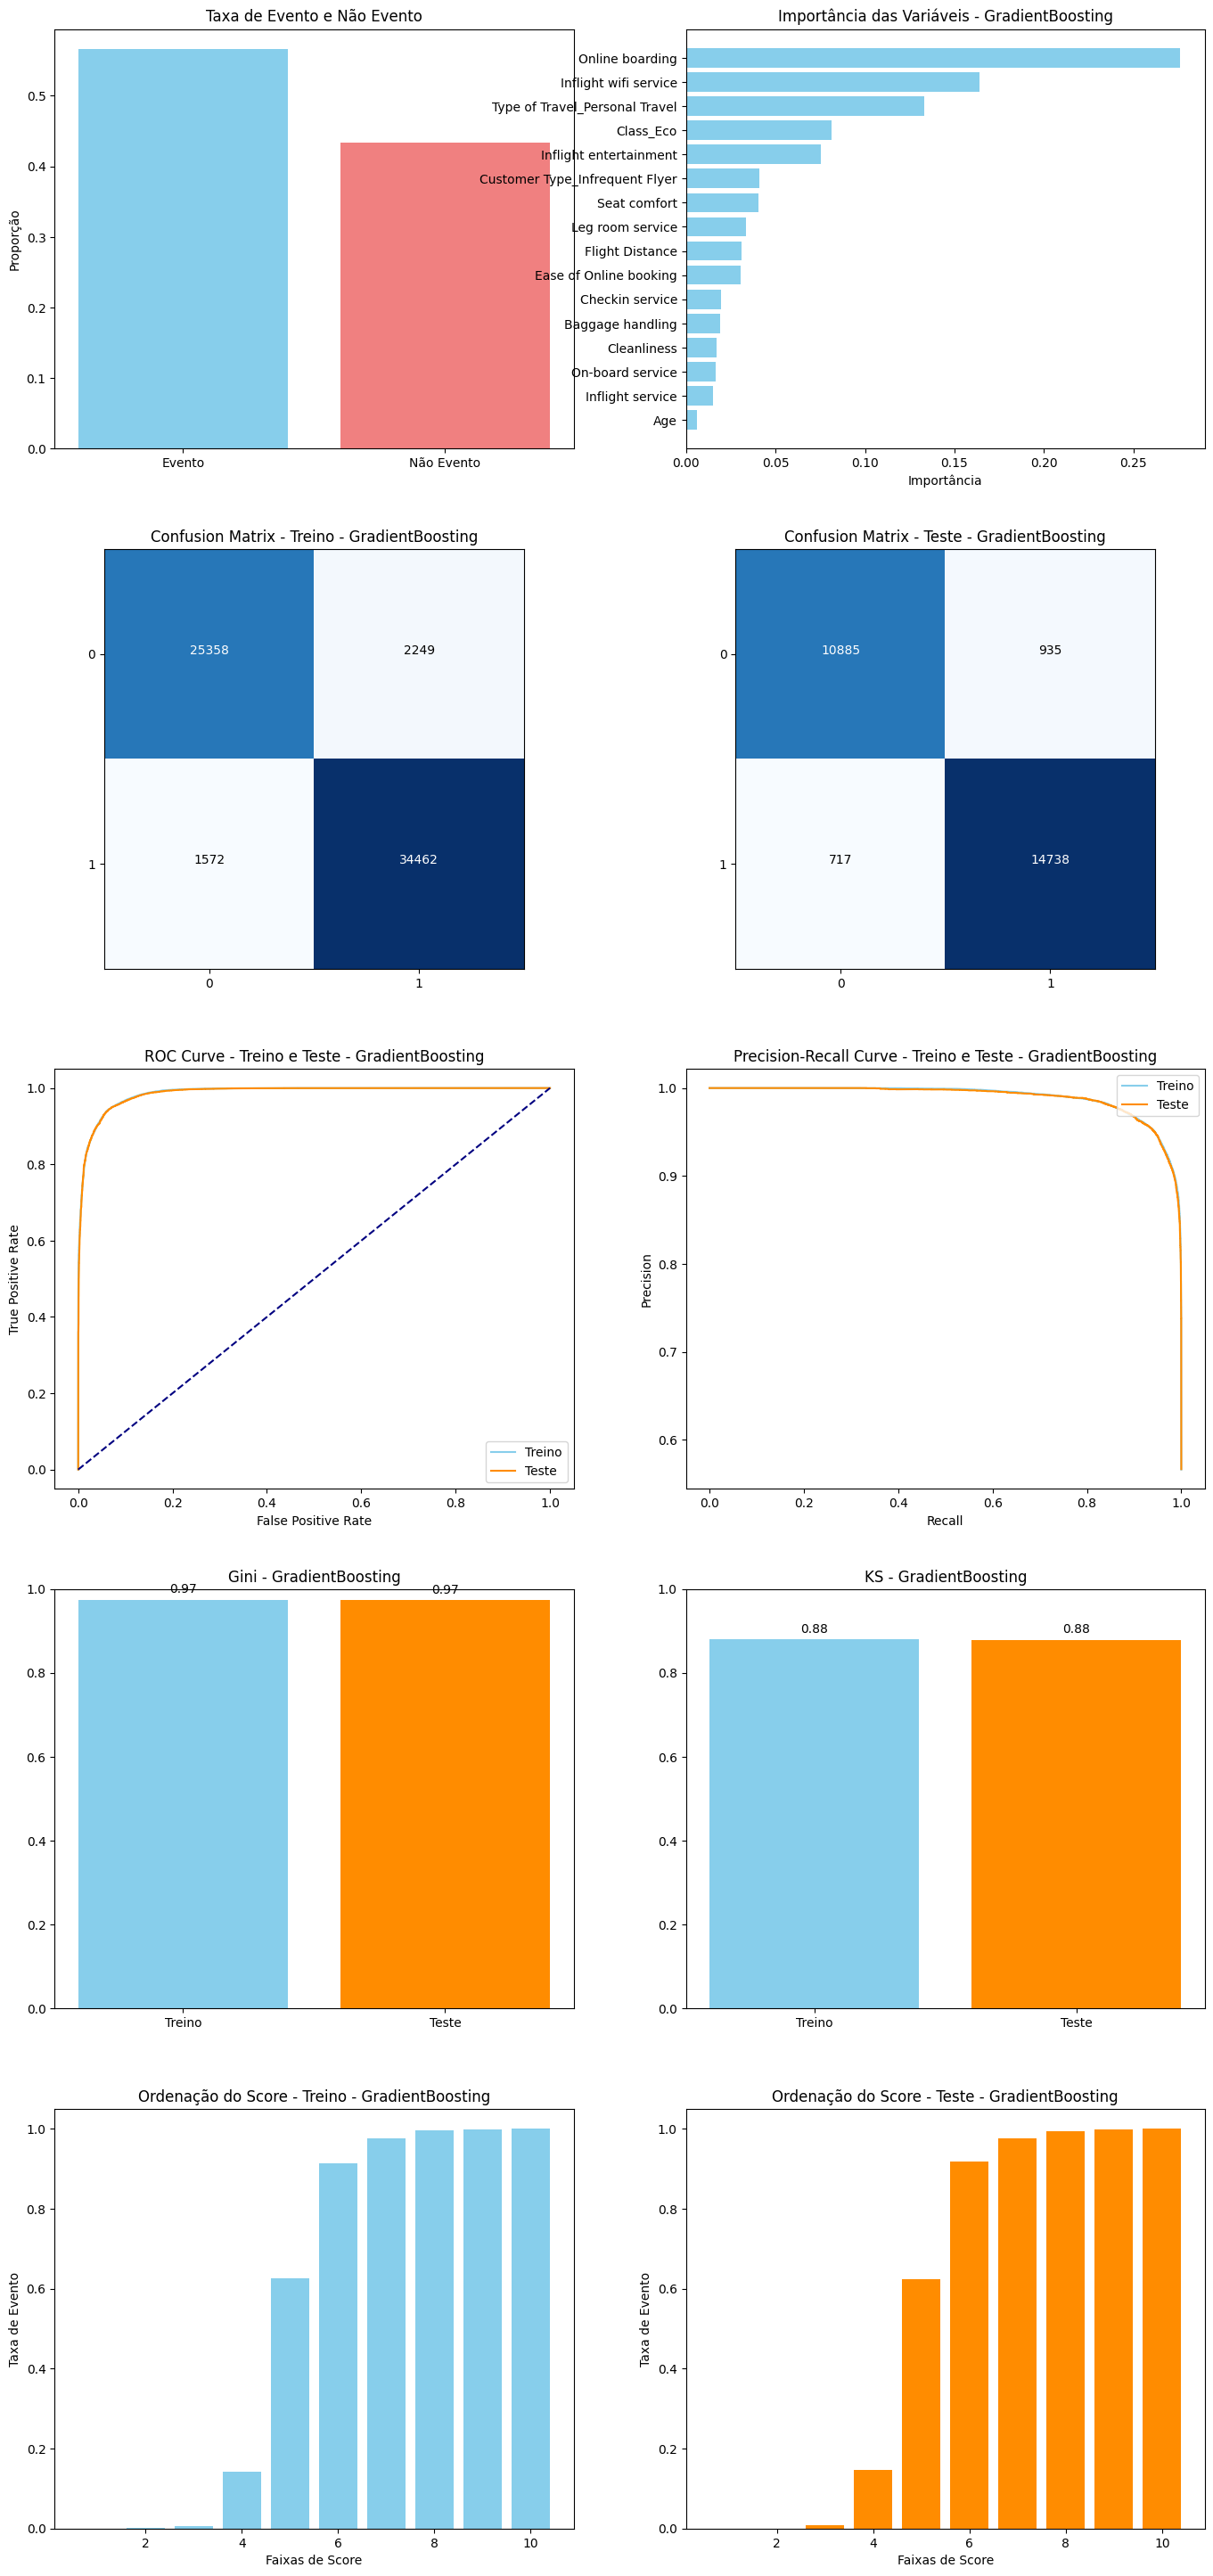

In [23]:
func.avaliar_modelo(X_train, y_train, X_test, y_test, best_model_gb,nm_modelo='GradientBoosting')

### Salvando os artefatos dos modelos treinados

In [24]:
# Salvando os modelos treinados em um arquivo pickle .pkl.
import pickle

with open('../../artifacts/best_model_dt.pkl', 'wb') as f:
  pickle.dump(best_model_dt, f)

with open('../../artifacts/best_model_rf.pkl', 'wb') as f:
  pickle.dump(best_model_rf, f)

with open('../../artifacts/best_model_gb.pkl', 'wb') as f:
  pickle.dump(best_model_gb, f)


# Lendo os modelos treinados.

with open('../../artifacts/best_model_dt.pkl', 'rb') as f:
    loaded_model_dt = pickle.load(f)

with open('../../artifacts/best_model_rf.pkl', 'rb') as f:
    loaded_model_rf = pickle.load(f)

with open('../../artifacts/best_model_gb.pkl', 'rb') as f:
    loaded_model_gb = pickle.load(f)

In [25]:
#testando o loaded_model_rf

loaded_model_rf

RandomForestClassifier(bootstrap=False, class_weight='balanced', max_depth=5,
                       min_samples_leaf=2, min_samples_split=0.01,
                       n_estimators=10, random_state=42)

In [27]:
# Modelo de RandomForest.
print(loaded_model_rf.get_params())

{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 5, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 2, 'min_samples_split': 0.01, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 10, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


### Avaliação dos modelos

### Criando tabela de métricas dos modelos treinados (base de teste)

In [29]:
# Criando uma lista com os modelos treinados.
models = {'Decision Tree': loaded_model_dt,
          'Random Forest': loaded_model_rf,
          'Gradient Boosting': loaded_model_gb,
          }

# Chamando a função com os datasets de treino e teste e os modelos carregados.
metrics_df = func.evaluate_models(X_train, y_train, X_test, y_test, models)

metrics_df

,Model,AUC-ROC,Accuracy,Precision,Recall,F1 Score,Gini,KS,Training_Time(s)
2,Gradient Boosting,0.986387,0.939432,0.940343,0.953607,0.946929,0.972774,0.879101,0.162927
1,Random Forest,0.975613,0.918863,0.943648,0.911226,0.927154,0.951225,0.848562,0.070682
0,Decision Tree,0.943808,0.867718,0.861740,0.913038,0.886648,0.887617,0.722981,0.044508
